In [2]:
import os
import re
import time
import torch
import torch.nn as nn
import torch.optim as optim
import numpy
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

torch.manual_seed(1)

In [132]:
#Let's get the data
def load_data(path="../data/poetryFromTang.txt", length=5000):
    df = pd.read_csv(path, names=["_"])[:length].values
    from itertools import chain
    s = sum(df, [])
    return ''.join(list(zip(*df))[0])

x = load_data("../data/poetryFromTang.txt")

print(x[:50])

def clean_text(x):
  x = [re.sub(r'[。， ]+', '',i) for i in x]
  x = [i for i in x if i]
  return x

x = clean_text(x)

print(x[:50])

#x_train, x_val= train_test_split(x, test_size=0.2)

print(len(x))

巴山上峡重复重，阳台碧峭十二峰。荆王猎时逢暮雨，夜卧高丘梦神女。轻红流烟湿艳姿，行云飞去明星稀。目极
['巴', '山', '上', '峡', '重', '复', '重', '阳', '台', '碧', '峭', '十', '二', '峰', '荆', '王', '猎', '时', '逢', '暮', '雨', '夜', '卧', '高', '丘', '梦', '神', '女', '轻', '红', '流', '烟', '湿', '艳', '姿', '行', '云', '飞', '去', '明', '星', '稀', '目', '极', '魂', '断', '望', '不', '见', '猿']
13324


In [190]:
#Simple Dict for embedding
def build_dict(x):
    ret = []
    for i in x:
        ret += [j for j in i.split()]
    return list(set(ret))

d = build_dict(x)

word2idx = {d[i]:i for i in range(len(d))}

pad_idx = len(word2idx)

#word2idx["<EOS>"] = pad_idx

idx2word = {word2idx[key]:key for key in word2idx.keys()}

vocab_size = len(word2idx)

n_classes = 5

print("vocab_size: ", vocab_size)


vocab_size:  2509


In [191]:
def get_dataset(x):
    return [word2idx[i] for i in x]
    
dataset = get_dataset(x)

print(dataset[:50])

[926, 415, 1628, 797, 2215, 1466, 2215, 203, 1170, 1328, 2110, 1572, 1698, 1479, 726, 1540, 434, 1182, 1561, 1935, 2106, 1989, 1459, 217, 2441, 419, 2350, 739, 2370, 819, 1141, 2496, 1224, 631, 270, 1820, 1251, 2270, 32, 2435, 1295, 864, 57, 1283, 1577, 479, 1259, 1917, 1617, 261]


In [192]:
class LSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, num_layers=1):
        super().__init__()
        self.hidden_dim = hidden_dim

        self.num_layers = num_layers

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers)

        self.fc = nn.Linear(embedding_dim, vocab_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        out = F.log_softmax(self.fc(lstm_out.view(len(sentence), -1)), dim=1)
        return out
    
    def predict(self, start, max_length=max_length):
        x = self.word_embeddings(start).unsqueeze(0).view(1, 1, -1)

        hidden = (torch.zeros(self.num_layers, 1, net.hidden_dim), torch.zeros(self.num_layers, 1, net.hidden_dim))
        from copy import copy
        lstm_out = copy(x)

        for i in range(max_length-1):
            x, hidden = net.lstm(x, hidden)
            lstm_out = torch.cat([lstm_out, x])

        out = F.log_softmax(net.fc(lstm_out.view(max_length, -1)), dim=1)

        out = torch.argmax(out,dim=1)

        return out.tolist()[:max_length-1]


In [193]:
EMBEDDING_DIM = 100
HIDDEN_DIM = 100
max_length = 14
net = LSTM(embedding_dim=EMBEDDING_DIM, hidden_dim=HIDDEN_DIM, vocab_size=vocab_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.005)

loss_list = []

for epoch in range(30):
    i = 0
    current_loss = 0
    while i + max_length < len(dataset):
        net.zero_grad()

        sentence_in, targets = torch.tensor(dataset[i:i+max_length]), torch.tensor(dataset[i+1:i+1+max_length])

        predicts = net(sentence_in)

        loss = criterion(predicts, targets)

        loss.backward()

        optimizer.step()

        current_loss += loss.item()

        loss_list.append(loss.item())

        i += max_length

    print("epoch: ", epoch, "current_loss: ", current_loss)


epoch:  0 current_loss:  7128.155601501465
epoch:  1 current_loss:  6144.177466392517
epoch:  2 current_loss:  5056.497151136398
epoch:  3 current_loss:  3979.2813556194305
epoch:  4 current_loss:  3088.198271870613
epoch:  5 current_loss:  2373.114567399025
epoch:  6 current_loss:  1828.2323039472103
epoch:  7 current_loss:  1434.852556437254
epoch:  8 current_loss:  1164.15449026227
epoch:  9 current_loss:  988.2242359593511
epoch:  10 current_loss:  844.0087458491325
epoch:  11 current_loss:  711.3225426077843
epoch:  12 current_loss:  625.8627610467374
epoch:  13 current_loss:  588.7339374609292
epoch:  14 current_loss:  574.0012425780296
epoch:  15 current_loss:  548.4214706402272
epoch:  16 current_loss:  495.2346380352974
epoch:  17 current_loss:  469.95432402193546
epoch:  18 current_loss:  448.27518858760595
epoch:  19 current_loss:  470.8339929310605
epoch:  20 current_loss:  448.916053539142
epoch:  21 current_loss:  423.2501573972404
epoch:  22 current_loss:  406.9146209564

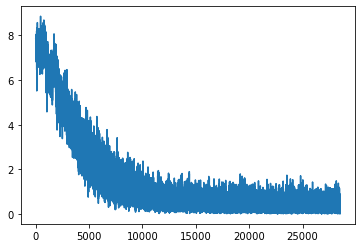

In [194]:
plt.plot(loss_list)
plt.show()

In [195]:
def generate(heads=["卢", "博", "好", "帅"], max_length=max_length):
    for start in heads:
        x = torch.tensor(word2idx[start])

        predicts = net.predict(x, max_length)

        sentence = [start] + [idx2word[i] for i in predicts]
        
        sentence.insert(len(sentence)//2, ",")

        sentence.append(".")

        print(''.join(sentence))


generate()

卢般英逢白白枝,天吹城觉楼城城.
博臭叶冥明千闻,云生生旌毛生生.
好素鸟觉幽意手,心心词大冈孙夫.
帅步奋文扬青小,敌落骊隔青双衣.
